<a href="https://colab.research.google.com/github/UN-GCPDS/curso_IA_CHEC/blob/main/Modulo5/cuadernos/Ejercicios_series_de_tiempo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Logo UNAL CHEC](https://github.com/UN-GCPDS/curso_IA_CHEC/blob/main/logo_unal_chec.jpg?raw=1)

# **MÓDULO 5: PRÁCTICA - SERIES DE TIEMPO**

## **Descripción**

El objetivo de este ejercicio es aprender a seleccionar la técnica de validación adecuada para modelos de series temporales y aplicarla correctamente en un modelo de predicción. Trabajarás con un conjunto de datos que representa el número de pasajeros aéreos internacionales a lo largo del tiempo y utilizarás una red neuronal MLP o una LSTM para realizar las predicciones, también será tu elección.

### **Profesor - Sesión 9:** German Castellanos-Dominguez
### **Monitores - Sesión 9:** Danna Valentina Salazar Dubois y Juan Camilo Lugo Rojas

## **Conozcamos primero la base de datos**

El conjunto de datos utilizado es el Airline Passengers Dataset, que contiene el número mensual de pasajeros aéreos internacionales desde enero de 1949 hasta diciembre de 1960. Este conjunto de datos es ampliamente utilizado para análisis y modelado de series temporales debido a sus características distintivas de tendencia y estacionalidad.

Características Principales:

- Período de Tiempo: De enero de 1949 a diciembre de 1960.
- Frecuencia de Datos: Mensual.

In [ ]:
# @title .
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output

# Cargar el dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(url)

# Crear las opciones del menú desplegable
options = ['Ver columnas', 'Mostrar .info()', 'Mostrar .head()', 'Mostrar .describe()']

dropdown = widgets.Dropdown(
    options=options,
    description='Seleccione:',
)

output = widgets.Output()

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        with output:
            clear_output()
            if dropdown.value == 'Ver columnas':
                print('Columnas del DataFrame:')
                print(df.columns.tolist())
            elif dropdown.value == 'Mostrar .info()':
                print('Información del DataFrame:')
                df.info()
            elif dropdown.value == 'Mostrar .head()':
                print('Primeras filas del DataFrame:')
                display(df.head())
            elif dropdown.value == 'Mostrar .describe()':
                print('Estadísticas descriptivas del DataFrame:')
                display(df.describe())
            else:
                print('Seleccione una opción válida.')

dropdown.observe(on_change)

display(dropdown, output)


Dropdown(description='Seleccione:', options=('Ver columnas', 'Mostrar .info()', 'Mostrar .head()', 'Mostrar .d…

Output()

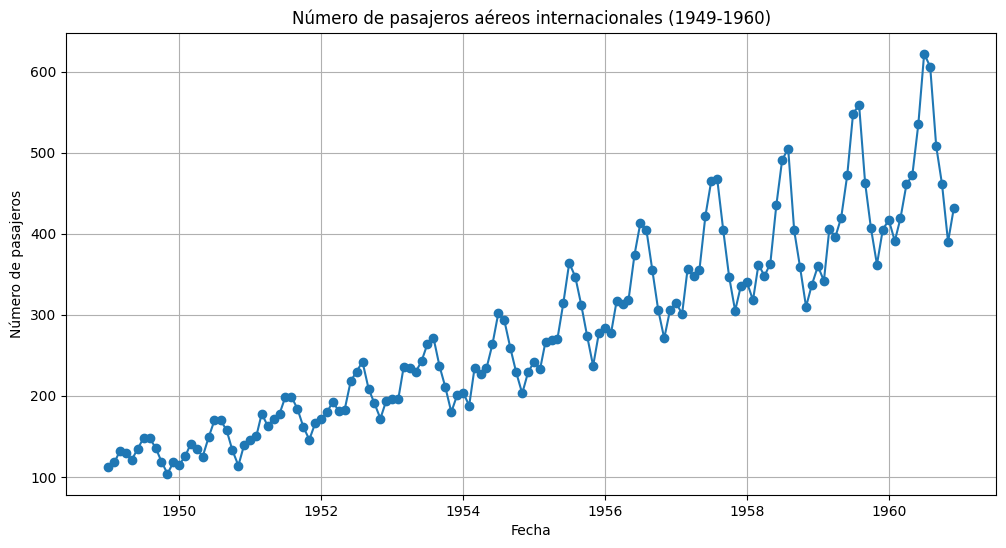

In [ ]:
# @title .

import matplotlib.pyplot as plt

# Convertir la columna 'Month' a formato datetime
df['Month'] = pd.to_datetime(df['Month'])

# Graficar la serie de tiempo
plt.figure(figsize=(12, 6))
plt.plot(df['Month'], df['Passengers'], marker='o')
plt.title('Número de pasajeros aéreos internacionales (1949-1960)')
plt.xlabel('Fecha')
plt.ylabel('Número de pasajeros')
plt.grid(True)
plt.show()

# **Elección y Entrenamiento del modelo**

In [ ]:
# @title .

# Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import ipywidgets as widgets
from IPython.display import display, clear_output

# Cargar el dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(url, usecols=[1])

# Preprocesamiento de datos
dataset = df.values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_scaled = scaler.fit_transform(dataset)

# Dividir en conjunto de entrenamiento y prueba
train_size = int(len(dataset_scaled) * 0.67)
test_size = len(dataset_scaled) - train_size
train, test = dataset_scaled[0:train_size], dataset_scaled[train_size:len(dataset_scaled)]

# Función para crear dataset con look_back
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back):
        X.append(dataset[i:(i+look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Definir el parámetro look_back
look_back = 3

# Crear los conjuntos de datos de entrenamiento y prueba
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Preparar los datos para LSTM y MLP
trainX_LSTM = np.reshape(trainX, (trainX.shape[0], look_back, 1))
testX_LSTM = np.reshape(testX, (testX.shape[0], look_back, 1))

# Crear un widget de salida para controlar las salidas
output = widgets.Output()

# Función para crear el modelo
def create_model(model_type):
    if model_type == 'LSTM':
        model = Sequential()
        model.add(LSTM(4, input_shape=(look_back, 1)))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
    elif model_type == 'MLP':
        model = Sequential()
        model.add(Dense(8, input_dim=look_back, activation='relu'))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
    else:
        print("Tipo de modelo no reconocido.")
        return None
    return model

# Función para evaluar el modelo y mostrar resultados
def evaluate_model(model, X_train_fold, y_train_fold, X_test_fold, y_test_fold, fold, train_scores, test_scores, train_indices, test_indices, model_type):
    # Predicciones
    trainPredict = model.predict(X_train_fold)
    testPredict = model.predict(X_test_fold)

    # Invertir las predicciones
    trainPredict = scaler.inverse_transform(trainPredict)
    y_train_fold_inv = scaler.inverse_transform([y_train_fold])
    testPredict = scaler.inverse_transform(testPredict)
    y_test_fold_inv = scaler.inverse_transform([y_test_fold])

    # Calcular RMSE
    trainScore = np.sqrt(mean_squared_error(y_train_fold_inv[0], trainPredict[:,0]))
    testScore = np.sqrt(mean_squared_error(y_test_fold_inv[0], testPredict[:,0]))
    print('Score de entrenamiento: %.2f RMSE' % (trainScore))
    print('Score de prueba: %.2f RMSE\n' % (testScore))

    # Almacenar los scores
    train_scores.append(trainScore)
    test_scores.append(testScore)

    # Gráficas
    total_data_length = len(dataset_scaled)
    trainPredictPlot = np.empty((total_data_length, 1))
    trainPredictPlot[:, :] = np.nan
    testPredictPlot = np.empty((total_data_length, 1))
    testPredictPlot[:, :] = np.nan

    # Mapear las predicciones al índice correcto
    trainPredictPlot[train_indices + look_back, :] = trainPredict
    testPredictPlot[test_indices + look_back, :] = testPredict

    plt.figure(figsize=(12,6))
    plt.plot(scaler.inverse_transform(dataset_scaled), label='Datos reales')
    plt.plot(trainPredictPlot, label='Predicción de entrenamiento')
    plt.plot(testPredictPlot, label='Predicción de prueba')
    plt.title(f'Fold {fold}: Modelo {model_type} usando validación {validation_dropdown.value}')
    plt.xlabel('Tiempo')
    plt.ylabel('Número de pasajeros')
    plt.legend()
    plt.show()

# Función para entrenar y evaluar el modelo según el tipo de validación
def train_and_evaluate(validation_type, n_folds, model_type):
    print(f"Entrenando y evaluando usando modelo {model_type}, validación {validation_type} con {n_folds} folds...\n")

    # Listas para almacenar los scores
    train_scores = []
    test_scores = []

    total_length = len(trainX)
    fold = 1

    # Seleccionar los datos según el modelo
    if model_type == 'LSTM':
        trainX_model = trainX_LSTM
        testX_model = testX_LSTM
    elif model_type == 'MLP':
        trainX_model = trainX
        testX_model = testX
    else:
        print("Tipo de modelo no reconocido.")
        return

    if validation_type == 'Deslizante':
        # Validación deslizante con tamaño fijo y test inmediatamente después
        train_window_size = total_length // (n_folds + 1)
        test_window_size = train_window_size
        for i in range(n_folds):
            print('')
            print(f"Fold {fold}")
            start_idx = i * train_window_size
            end_train_idx = start_idx + train_window_size
            end_test_idx = end_train_idx + test_window_size

            if end_test_idx > total_length:
                break

            X_train_fold = trainX_model[start_idx:end_train_idx]
            y_train_fold = trainY[start_idx:end_train_idx]
            X_test_fold = trainX_model[end_train_idx:end_test_idx]
            y_test_fold = trainY[end_train_idx:end_test_idx]

            train_indices = np.arange(start_idx, end_train_idx)
            test_indices = np.arange(end_train_idx, end_test_idx)

            model = create_model(model_type)
            model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=1, verbose=0)
            evaluate_model(model, X_train_fold, y_train_fold, X_test_fold, y_test_fold, fold, train_scores, test_scores, train_indices, test_indices, model_type)
            fold += 1

    elif validation_type == 'Expandible':
        # Validación expandible con test inmediatamente después
        train_window_size = total_length // (n_folds + 1)
        test_window_size = train_window_size
        for i in range(n_folds):
            print('')
            print(f"Fold {fold}")
            end_train_idx = train_window_size * (i + 1)
            start_test_idx = end_train_idx
            end_test_idx = start_test_idx + test_window_size

            if end_test_idx > total_length:
                break

            X_train_fold = trainX_model[:end_train_idx]
            y_train_fold = trainY[:end_train_idx]
            X_test_fold = trainX_model[start_test_idx:end_test_idx]
            y_test_fold = trainY[start_test_idx:end_test_idx]

            train_indices = np.arange(0, end_train_idx)
            test_indices = np.arange(start_test_idx, end_test_idx)

            model = create_model(model_type)
            model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=1, verbose=0)
            evaluate_model(model, X_train_fold, y_train_fold, X_test_fold, y_test_fold, fold, train_scores, test_scores, train_indices, test_indices, model_type)
            fold += 1

    else:
        print("Tipo de validación no reconocido.")
        return

    # Calcular el promedio de los scores
    avg_train_score = np.mean(train_scores)
    avg_test_score = np.mean(test_scores)
    print('\nPromedio de Score de entrenamiento: %.2f RMSE' % (avg_train_score))
    print('Promedio de Score de prueba: %.2f RMSE' % (avg_test_score))

# Crear el menú desplegable de validación sin la opción 'Aleatoria'
validation_dropdown = widgets.Dropdown(
    options=['Deslizante', 'Expandible'],
    value='Deslizante',
    description='Validación:',
)

# Crear el menú desplegable para seleccionar el modelo
model_dropdown = widgets.Dropdown(
    options=['LSTM', 'MLP'],
    value='LSTM',
    description='Modelo:',
)

# Crear el control para seleccionar el número de folds
folds_slider = widgets.IntSlider(
    value=2,
    min=2,
    max=5,
    step=1,
    description='Número de folds:',
)

# Crear un botón para ejecutar
run_button = widgets.Button(
    description='Ejecutar',
    button_style='success',
)

# Función para actualizar cuando se presiona el botón
def on_button_clicked(b):
    with output:
        clear_output(wait=True)
        train_and_evaluate(validation_dropdown.value, folds_slider.value, model_dropdown.value)

run_button.on_click(on_button_clicked)

# Mostrar los widgets y la salida
display(widgets.VBox([model_dropdown, validation_dropdown, folds_slider, run_button, output]))

# Ejecutar la función inicialmente con los valores predeterminados
with output:
    train_and_evaluate(validation_dropdown.value, folds_slider.value, model_dropdown.value)


# **Tips para Escoger la Mejor Opción**

Para ayudarte a escoger el mejor modelo y técnica de validación para tu práctica de predicción de series temporales, aquí tienes algunos consejos y consideraciones:

### **Elección del Modelo: LSTM vs MLP**

1. **Naturaleza de los Datos**:
   - **LSTM (Long Short-Term Memory)**:
     - Diseñado específicamente para capturar dependencias temporales y patrones a largo plazo en datos secuenciales.
     - Ideal para series temporales con tendencias, estacionalidades y autocorrelaciones.
     - Si tus datos muestran patrones complejos en el tiempo, como ciclos o tendencias no lineales, LSTM puede capturar estas relaciones mejor que un MLP.
   - **MLP (Multi-Layer Perceptron)**:
     - Es una red neuronal de alimentación hacia adelante sin memoria temporal.
     - Puede funcionar bien si los patrones temporales se pueden capturar mediante lag variables o características derivadas.
     - Requiere más ingeniería de características para capturar la temporalidad.

2. **Complejidad del Modelo y Recursos Computacionales**:
   - **LSTM**:
     - Más complejo y computacionalmente intensivo.
     - Puede ser propenso a sobreajustarse si el conjunto de datos es pequeño.
   - **MLP**:
     - Menos demandante computacionalmente.
     - Más rápido de entrenar y evaluar.

3. **Tamaño del Conjunto de Datos**:
   - Si tienes un conjunto de datos **grande**, LSTM puede aprovechar mejor la información disponible.
   - Con un conjunto de datos **pequeño**, MLP puede ser más adecuado para evitar el sobreajuste.

4. **Interpretabilidad**:
   - **MLP** es generalmente más fácil de interpretar y explicar que LSTM.
   - Si la interpretabilidad es crucial, MLP puede ser preferible.

### **Elección de la Técnica de Validación: Deslizante vs Expandible**

1. **Validación Deslizante (Ventana Deslizante)**:
   - Simula un entorno donde entrenas y pruebas el modelo en diferentes ventanas de tiempo.
   - **Ventajas**:
     - Te permite evaluar la estabilidad y consistencia del modelo a lo largo del tiempo.
     - Útil si sospechas que la relación entre variables cambia con el tiempo.
   - **Consideraciones**:
     - El tamaño de las ventanas de entrenamiento y prueba debe ser suficiente para capturar los patrones relevantes.
     - Puede ser menos eficiente en términos de uso de datos, ya que no utiliza todo el conjunto de datos para entrenar.

2. **Validación Expandible (Ventana Expandible)**:
   - Emula un escenario real donde acumulas datos con el tiempo y retrainas el modelo agregando nueva información.
   - **Ventajas**:
     - Aprovecha todos los datos disponibles hasta el punto actual para entrenar.
     - Refleja cómo se implementaría un modelo en producción.
   - **Consideraciones**:
     - Puede ser más propenso a sobreajuste si los datos más antiguos son menos relevantes.
     - Es útil si asumes que los patrones en los datos son relativamente estables a lo largo del tiempo.

### **Consejos Prácticos para la Elección**

- **Analiza la Serie Temporal**:
  - Observa si hay tendencias, estacionalidades o cambios estructurales.
  - Si hay **patrones complejos**, LSTM con validación expandible puede capturarlos mejor.

- **Evalúa el Rendimiento**:
  - Ejecuta ambos modelos con ambas técnicas de validación y compara el **RMSE** y las gráficas de predicción.
  - Observa no solo el error promedio, sino también cómo se comporta el modelo en diferentes períodos.

- **Considera la Estabilidad del Modelo**:
  - Si el modelo muestra variaciones significativas en el rendimiento entre diferentes folds, puede indicar inestabilidad.
  - La validación deslizante puede ayudarte a identificar esto.

- **Prevención de Sobreajuste**:
  - Asegúrate de que el modelo generaliza bien y no solo memoriza el conjunto de entrenamiento.
  - Observa la diferencia entre los scores de entrenamiento y prueba.

- **Requisitos del Negocio**:
  - Si necesitas un modelo que pueda actualizarse fácilmente con nuevos datos, la validación expandible refleja mejor este escenario.
  - Si estás interesado en la robustez del modelo a través del tiempo, la validación deslizante es más apropiada.

- **Recursos Disponibles**:
  - Considera el tiempo de entrenamiento y los recursos computacionales.
  - Si son limitados, un MLP con validación expandible puede ser más práctico.

### **Recomendación Final**

- **Si buscas capturar patrones temporales complejos y tienes suficiente capacidad computacional**, **elige LSTM**.
- **Si prefieres un modelo más simple y rápido de entrenar**, o si los patrones temporales pueden ser capturados con menos complejidad, **elige MLP**.
- **Para reflejar un escenario de producción y aprovechar al máximo los datos disponibles**, la **validación expandible** es generalmente más apropiada.
- **Para evaluar la consistencia del modelo en diferentes períodos y detectar posibles inestabilidades**, utiliza la **validación deslizante**.

Recuerda que no hay una solución única que funcione para todos los casos. Lo mejor es experimentar con ambas opciones y basar tu decisión en los resultados obtenidos y las necesidades específicas de tu proyecto.

# **A tener en cuenta:**

No todas las series de tiempo son fáciles de manejar, en algunos casos, es necesario utilizar modelos más avanzados como transformadores (transformers) o incluir variables exógenas.

### **Desafíos en el Modelado de Series de Tiempo**

1. **Patrones Complejos y No Lineales**:
   - **No linealidades**: Muchas series de tiempo presentan relaciones no lineales que los modelos simples no pueden capturar eficazmente.
   - **Estacionalidades Múltiples**: Algunas series tienen patrones estacionales en diferentes escalas de tiempo (diarias, semanales, mensuales), lo que aumenta la complejidad.
   - **Tendencias Cambiantes**: Las tendencias pueden cambiar abruptamente debido a factores externos, dificultando la predicción con modelos estáticos.

2. **Dependencias a Largo Plazo**:
   - **Memoria a Largo Plazo**: Los modelos tradicionales pueden tener dificultades para capturar dependencias que ocurren en lapsos de tiempo prolongados.
   - **Efectos Retardados**: Algunos eventos afectan la serie de tiempo después de un retraso significativo, lo que requiere modelos capaces de reconocer estas relaciones.

3. **Datos Ruidosos y Anomalías**:
   - **Ruido**: La presencia de ruido en los datos puede confundir a los modelos simples, reduciendo su precisión.
   - **Valores Atípicos**: Las anomalías pueden influir desproporcionadamente en los modelos que no están diseñados para manejarlas.

4. **Influencia de Factores Externos**:
   - **Variables Exógenas**: Factores externos como eventos económicos, condiciones climáticas o cambios legislativos pueden influir significativamente en la serie de tiempo.
   - **Interacciones Complejas**: La relación entre las variables internas y externas puede ser compleja y no lineal.

